In [ ]:
# ============================================
# STEP 1: Install and Import Libraries
# ============================================
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import warnings
import zipfile
from tqdm import tqdm
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

print("✅ Libraries installed successfully!\n")

✅ Libraries installed successfully!



In [ ]:
# ============================================
# STEP 2: Download MIND Small Dataset
# ============================================
print("📥 Downloading MIND Small Dataset...")

!wget -q https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip -O MINDsmall_train.zip
!wget -q https://mind201910small.blob.core.windows.net/release/MINDsmall_dev.zip -O MINDsmall_dev.zip

print("📦 Extracting files...")
with zipfile.ZipFile('MINDsmall_train.zip', 'r') as zip_ref:
    zip_ref.extractall('MINDsmall_train')
with zipfile.ZipFile('MINDsmall_dev.zip', 'r') as zip_ref:
    zip_ref.extractall('MINDsmall_dev')

print("✅ Dataset ready!\n")

In [ ]:
import zipfile
import os
import shutil

def extract_and_flatten(zip_path, target_dir):
    """
    Extracts a ZIP file, detects if the contents are wrapped in a single
    root folder (e.g., 'MINDsmall_dev/'), and moves the contents directly
    into the specified target_dir, avoiding nested folders.
    """

    if not os.path.exists(zip_path):
        print(f"⚠️ Warning: ZIP file not found: {zip_path}")
        return

    # Create a temporary extraction directory
    temp_dir = f"temp_{target_dir}"
    os.makedirs(temp_dir, exist_ok=True)

    print(f"📦 Extracting {zip_path} to temporary folder...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the root folder inside the temporary directory
    extracted_contents = os.listdir(temp_dir)
    source_root = temp_dir

    # If there is exactly one folder inside temp_dir, that's the one we need to flatten
    if len(extracted_contents) == 1 and os.path.isdir(os.path.join(temp_dir, extracted_contents[0])):
        source_root = os.path.join(temp_dir, extracted_contents[0])

    # Ensure the final target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Move all files/folders from the source root to the final target directory
    print(f"⬆️ Flattening structure: Moving contents from {source_root} to {target_dir}")
    for item in os.listdir(source_root):
        shutil.move(os.path.join(source_root, item), target_dir)

    # Clean up the temporary directory
    shutil.rmtree(temp_dir)
    print(f"✅ Successfully extracted and flattened {zip_path} into {target_dir}")

# =========================================================================
# MODIFIED EXTRACTION LOGIC
# =========================================================================

# The code will now create:
# - 'MINDsmall_train/' containing 'news.tsv', 'behaviors.tsv', etc.
# - 'MINDsmall_dev/' containing 'news.tsv', 'behaviors.tsv', etc.

extract_and_flatten('MINDsmall_train.zip', 'MINDsmall_train')
extract_and_flatten('MINDsmall_dev.zip', 'MINDsmall_dev')

print("\n✅ Dataset extracted and flattened!\n")

📦 Extracting MINDsmall_train.zip to temporary folder...
⬆️ Flattening structure: Moving contents from temp_MINDsmall_train/MINDsmall_train to MINDsmall_train
✅ Successfully extracted and flattened MINDsmall_train.zip into MINDsmall_train
📦 Extracting MINDsmall_dev.zip to temporary folder...
⬆️ Flattening structure: Moving contents from temp_MINDsmall_dev/MINDsmall_dev to MINDsmall_dev
✅ Successfully extracted and flattened MINDsmall_dev.zip into MINDsmall_dev

✅ Dataset extracted and flattened!



In [ ]:
# ============================================
# STEP 3: Load News Data
# ============================================
print("📰 Loading news articles...")

def load_news(file_path):
    columns = ['news_id', 'category', 'subcategory', 'title', 'abstract',
               'url', 'title_entities', 'abstract_entities']
    news_df = pd.read_csv(file_path, sep='\t', names=columns, header=None)
    news_df['abstract'] = news_df['abstract'].fillna('')
    news_df['title'] = news_df['title'].fillna('')
    news_df['content'] = news_df['title'] + ' ' + news_df['abstract']
    return news_df

train_news = load_news('MINDsmall_train/news.tsv')
dev_news = load_news('MINDsmall_dev/news.tsv')
all_news = pd.concat([train_news, dev_news]).drop_duplicates(subset='news_id').reset_index(drop=True)

print(f"✅ Total articles: {len(all_news)}\n")

📰 Loading news articles...
✅ Total articles: 65238



In [ ]:
# STEP 4: Load User Behaviors
# ============================================
print("👥 Loading user behaviors...")

def load_behaviors(file_path):
    columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']
    behaviors_df = pd.read_csv(file_path, sep='\t', names=columns, header=None)
    behaviors_df['history'] = behaviors_df['history'].fillna('').apply(lambda x: x.split())
    behaviors_df['impressions'] = behaviors_df['impressions'].apply(lambda x: x.split())
    return behaviors_df

train_behaviors = load_behaviors('MINDsmall_train/behaviors.tsv')
dev_behaviors = load_behaviors('MINDsmall_dev/behaviors.tsv')

print(f"✅ Training: {len(train_behaviors)} records, {train_behaviors['user_id'].nunique()} users")
print(f"✅ Validation: {len(dev_behaviors)} records, {dev_behaviors['user_id'].nunique()}\n")


👥 Loading user behaviors...
✅ Training: 156965 records, 50000 users
✅ Validation: 73152 records, 50000



In [ ]:
# ============================================
# STEP 5: Build Enhanced Features
# ============================================
print("🔧 Building enhanced features...")

# News ID mappings
news_id_to_idx = {news_id: idx for idx, news_id in enumerate(all_news['news_id'])}
idx_to_news_id = {idx: news_id for news_id, idx in news_id_to_idx.items()}

# Category encoding
category_to_idx = {cat: idx for idx, cat in enumerate(all_news['category'].unique())}
all_news['category_idx'] = all_news['category'].map(category_to_idx)

# Build user history
def build_user_history(behaviors_df):
    user_history = {}
    for _, row in behaviors_df.iterrows():
        user_id = row['user_id']
        history = [nid for nid in row['history'] if nid in news_id_to_idx]
        if user_id not in user_history:
            user_history[user_id] = []
        user_history[user_id].extend(history)
    for user_id in user_history:
        user_history[user_id] = list(set(user_history[user_id]))
    return user_history

train_user_history = build_user_history(train_behaviors)
dev_user_history = build_user_history(dev_behaviors)

print(f"✅ User histories built\n")

🔧 Building enhanced features...
✅ User histories built



In [ ]:
# ============================================
# STEP 6: Advanced Feature Extraction
# ============================================
print("🔍 Extracting advanced features...")

# 1. Enhanced TF-IDF with better parameters
tfidf = TfidfVectorizer(
    max_features=10000,  # Increased features
    stop_words='english',
    ngram_range=(1, 3),  # Include trigrams
    min_df=3,
    max_df=0.7,
    sublinear_tf=True  # Use log scaling
)

tfidf_matrix = tfidf.fit_transform(all_news['content'])
print(f"✅ TF-IDF matrix: {tfidf_matrix.shape}")

# 2. Dimensionality reduction with SVD for better performance
print("🔄 Applying SVD for dimensionality reduction...")
svd = TruncatedSVD(n_components=300, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)
tfidf_reduced = normalize(tfidf_reduced)
print(f"✅ Reduced features: {tfidf_reduced.shape}")

# 3. Category embeddings (one-hot) - FIXED
from sklearn.preprocessing import OneHotEncoder
category_encoder = OneHotEncoder(sparse_output=True)
category_features = category_encoder.fit_transform(all_news[['category_idx']])
print(f"✅ Category features: {category_features.shape}")

# 4. Combine features (content + category) - FIXED
from scipy.sparse import hstack, csr_matrix
# Convert tfidf_reduced to sparse matrix first
tfidf_reduced_sparse = csr_matrix(tfidf_reduced)
combined_features = hstack([tfidf_reduced_sparse, category_features])
combined_features = normalize(combined_features)
print(f"✅ Combined features: {combined_features.shape}\n")

🔍 Extracting advanced features...
✅ TF-IDF matrix: (65238, 10000)
🔄 Applying SVD for dimensionality reduction...
✅ Reduced features: (65238, 300)
✅ Category features: (65238, 18)
✅ Combined features: (65238, 318)



In [ ]:
# ============================================
# STEP 7: Build Collaborative Filtering Component
# ============================================
print("🤝 Building collaborative filtering...")

# Build user-item interaction matrix
def build_interaction_matrix(user_history, news_id_to_idx):
    n_users = len(user_history)
    n_items = len(news_id_to_idx)

    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_history.keys())}

    # Sparse matrix for memory efficiency
    from scipy.sparse import lil_matrix
    interaction_matrix = lil_matrix((n_users, n_items))

    for user_id, history in user_history.items():
        user_idx = user_to_idx[user_id]
        for news_id in history:
            if news_id in news_id_to_idx:
                item_idx = news_id_to_idx[news_id]
                interaction_matrix[user_idx, item_idx] = 1

    return interaction_matrix.tocsr(), user_to_idx

train_interaction_matrix, user_to_idx = build_interaction_matrix(train_user_history, news_id_to_idx)
print(f"✅ Interaction matrix: {train_interaction_matrix.shape}")

# Apply SVD for collaborative filtering
print("🔄 Computing collaborative filtering with SVD...")
cf_svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = cf_svd.fit_transform(train_interaction_matrix)
item_factors = cf_svd.components_.T
print(f"✅ User factors: {user_factors.shape}, Item factors: {item_factors.shape}\n")

🤝 Building collaborative filtering...
✅ Interaction matrix: (50000, 65238)
🔄 Computing collaborative filtering with SVD...
✅ User factors: (50000, 50), Item factors: (65238, 50)



In [ ]:
# ============================================
# STEP 8: Hybrid Recommendation System
# ============================================
print("🎯 Building hybrid recommendation engine...")

def get_hybrid_user_profile(user_history, combined_features, item_factors,
                            news_id_to_idx, content_weight=0.6, cf_weight=0.4):
    """Create hybrid user profile combining content and collaborative filtering"""

    if not user_history:
        return None, None

    indices = [news_id_to_idx[nid] for nid in user_history if nid in news_id_to_idx]

    if not indices:
        return None, None

    # Content-based profile
    content_profile = np.asarray(combined_features[indices].mean(axis=0)).flatten()

    # Collaborative filtering profile
    cf_profile = np.mean(item_factors[indices], axis=0)

    return content_profile, cf_profile

def recommend_hybrid(user_history, combined_features, item_factors,
                    news_id_to_idx, idx_to_news_id, top_n=10,
                    content_weight=0.6, cf_weight=0.4):
    """Hybrid recommendation combining content and collaborative filtering"""

    content_profile, cf_profile = get_hybrid_user_profile(
        user_history, combined_features, item_factors, news_id_to_idx,
        content_weight, cf_weight
    )

    if content_profile is None:
        return []

    # Content-based scores
    content_profile = content_profile.reshape(1, -1)
    content_scores = cosine_similarity(content_profile, combined_features).flatten()

    # Collaborative filtering scores
    cf_scores = np.dot(item_factors, cf_profile)

    # Combine scores
    hybrid_scores = content_weight * content_scores + cf_weight * cf_scores

    # Popularity boost (click frequency)
    all_histories = [nid for hist in train_user_history.values() for nid in hist]
    popularity = Counter(all_histories)
    popularity_scores = np.array([popularity.get(idx_to_news_id[i], 0) for i in range(len(idx_to_news_id))])
    popularity_scores = popularity_scores / (popularity_scores.max() + 1)  # Normalize

    # Final score with popularity boost
    final_scores = hybrid_scores + 0.1 * popularity_scores

    # Get top recommendations
    similar_indices = final_scores.argsort()[::-1]

    recommendations = []
    read_news_ids = set(user_history)

    for idx in similar_indices:
        news_id = idx_to_news_id[idx]
        if news_id not in read_news_ids:
            recommendations.append(news_id)
            if len(recommendations) >= top_n:
                break

    return recommendations

print("✅ Hybrid recommendation engine ready!\n")

🎯 Building hybrid recommendation engine...
✅ Hybrid recommendation engine ready!



In [ ]:
# ============================================
# STEP 9: Generate Sample Recommendations
# ============================================
print("💡 Testing hybrid recommendations...\n")

sample_users = list(dev_user_history.keys())[:3]

for i, user_id in enumerate(sample_users, 1):
    print(f"{'='*70}")
    print(f"USER {i}: {user_id}")
    print(f"{'='*70}")

    history = dev_user_history[user_id]
    print(f"📖 Read {len(history)} articles")

    if history[:2]:
        print("\n🔹 Recently read:")
        for nid in history[:2]:
            if nid in all_news['news_id'].values:
                article = all_news[all_news['news_id'] == nid].iloc[0]
                print(f"   • [{article['category']}] {article['title'][:55]}...")

    recommendations = recommend_hybrid(
        history, combined_features, item_factors,
        news_id_to_idx, idx_to_news_id, top_n=5
    )

    print(f"\n💡 Top 5 Hybrid Recommendations:")
    for j, nid in enumerate(recommendations, 1):
        if nid in all_news['news_id'].values:
            article = all_news[all_news['news_id'] == nid].iloc[0]
            print(f"   {j}. [{article['category']}] {article['title'][:55]}...")
    print()


💡 Testing hybrid recommendations...

USER 1: U80234
📖 Read 15 articles

🔹 Recently read:
   • [autos] This restored 1968 Winnebago is beyond adorable...
   • [news] Alexandria Ocasio-Cortez 'sincerely' apologizes for blo...

💡 Top 5 Hybrid Recommendations:
   1. [news] Felicity Huffman Is Scheduled to Be Released from Priso...
   2. [news] 8Chan Returns as Japanese Pun 8kun...
   3. [news] Hard Rock effort switches to recovery, officials workin...
   4. [news] Meghan McCain confronts Trump Jr.: 'You and your family...
   5. [news] Man gets prison for stealing lemur from California zoo...

USER 2: U60458
📖 Read 13 articles

🔹 Recently read:
   • [news] Massive fentanyl seizure 'enough to kill everyone' in O...
   • [lifestyle] A part of Windsor Castle that's been closed to the publ...

💡 Top 5 Hybrid Recommendations:
   1. [news] Four flight attendants were arrested in Miami's airport...
   2. [news] Smartphone S.O.S. App Saves NYC Teen From Ambush By Bic...
   3. [finance] Flight shami

In [ ]:
# ============================================
# STEP 10: Comprehensive Evaluation
# ============================================
print("📈 Evaluating hybrid model...\n")

def parse_impressions(impressions_list):
    impressions = []
    for imp in impressions_list:
        parts = imp.split('-')
        if len(parts) == 2:
            impressions.append((parts[0], int(parts[1])))
    return impressions

def evaluate_hybrid_model(behaviors_df, user_history, combined_features, item_factors,
                         news_id_to_idx, idx_to_news_id, k_values=[5, 10, 20]):

    all_aucs = []
    all_mrrs = []
    precision_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    ndcg_at_k = {k: [] for k in k_values}

    print("Evaluating on 500 validation samples...")

    for idx, row in tqdm(behaviors_df.head(500).iterrows(), total=500):
        user_id = row['user_id']

        if user_id not in user_history:
            continue

        history = user_history[user_id]
        impressions = parse_impressions(row['impressions'])

        if not impressions or len(impressions) < 2:
            continue

        content_profile, cf_profile = get_hybrid_user_profile(
            history, combined_features, item_factors, news_id_to_idx
        )

        if content_profile is None:
            continue

        content_profile = content_profile.reshape(1, -1)

        scores = []
        labels = []

        for news_id, label in impressions:
            if news_id in news_id_to_idx:
                idx_news = news_id_to_idx[news_id]

                # Hybrid score
                content_score = cosine_similarity(content_profile, combined_features[idx_news].reshape(1, -1))[0][0]
                cf_score = np.dot(item_factors[idx_news], cf_profile)
                hybrid_score = 0.6 * content_score + 0.4 * cf_score

                scores.append(hybrid_score)
                labels.append(label)

        if len(set(labels)) < 2 or len(scores) == 0:
            continue

        # AUC
        try:
            auc = roc_auc_score(labels, scores)
            all_aucs.append(auc)
        except:
            pass

        # MRR
        sorted_indices = np.argsort(scores)[::-1]
        for rank, idx in enumerate(sorted_indices, 1):
            if labels[idx] == 1:
                all_mrrs.append(1.0 / rank)
                break

        # Precision, Recall, NDCG at K
        for k in k_values:
            top_k_indices = sorted_indices[:k]
            top_k_labels = [labels[i] for i in top_k_indices]

            if len(top_k_labels) > 0:
                precision_at_k[k].append(sum(top_k_labels) / len(top_k_labels))

            total_relevant = sum(labels)
            if total_relevant > 0:
                recall_at_k[k].append(sum(top_k_labels) / total_relevant)

                dcg = sum([labels[i] / np.log2(rank + 2) for rank, i in enumerate(top_k_indices)])
                idcg = sum([1.0 / np.log2(rank + 2) for rank in range(min(k, total_relevant))])
                if idcg > 0:
                    ndcg_at_k[k].append(dcg / idcg)

    results = {
        'AUC': np.mean(all_aucs) if all_aucs else 0,
        'MRR': np.mean(all_mrrs) if all_mrrs else 0,
    }

    for k in k_values:
        results[f'Precision@{k}'] = np.mean(precision_at_k[k]) if precision_at_k[k] else 0
        results[f'Recall@{k}'] = np.mean(recall_at_k[k]) if recall_at_k[k] else 0
        results[f'NDCG@{k}'] = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0

    return results

# Evaluate
hybrid_results = evaluate_hybrid_model(
    dev_behaviors, dev_user_history, combined_features, item_factors,
    news_id_to_idx, idx_to_news_id, k_values=[5, 10, 20]
)

print("\n" + "="*70)
print("📊 HYBRID MODEL PERFORMANCE")
print("="*70)
print(f"AUC Score:        {hybrid_results['AUC']:.4f}")
print(f"MRR Score:        {hybrid_results['MRR']:.4f}")
print("-" * 70)
print(f"Precision@5:      {hybrid_results['Precision@5']:.4f}")
print(f"Recall@5:         {hybrid_results['Recall@5']:.4f}")
print(f"NDCG@5:           {hybrid_results['NDCG@5']:.4f}")
print("-" * 70)
print(f"Precision@10:     {hybrid_results['Precision@10']:.4f}")
print(f"Recall@10:        {hybrid_results['Recall@10']:.4f}")
print(f"NDCG@10:          {hybrid_results['NDCG@10']:.4f}")
print("-" * 70)
print(f"Precision@20:     {hybrid_results['Precision@20']:.4f}")
print(f"Recall@20:        {hybrid_results['Recall@20']:.4f}")
print(f"NDCG@20:          {hybrid_results['NDCG@20']:.4f}")
print("="*70)

📈 Evaluating hybrid model...

Evaluating on 500 validation samples...


100%|██████████| 500/500 [00:22<00:00, 22.26it/s]


📊 HYBRID MODEL PERFORMANCE
AUC Score:        0.6078
MRR Score:        0.3214
----------------------------------------------------------------------
Precision@5:      0.1282
Recall@5:         0.4413
NDCG@5:           0.3057
----------------------------------------------------------------------
Precision@10:     0.1167
Recall@10:        0.6291
NDCG@10:          0.3706
----------------------------------------------------------------------
Precision@20:     0.1083
Recall@20:        0.7737
NDCG@20:          0.4117



📊 Creating performance visualizations...


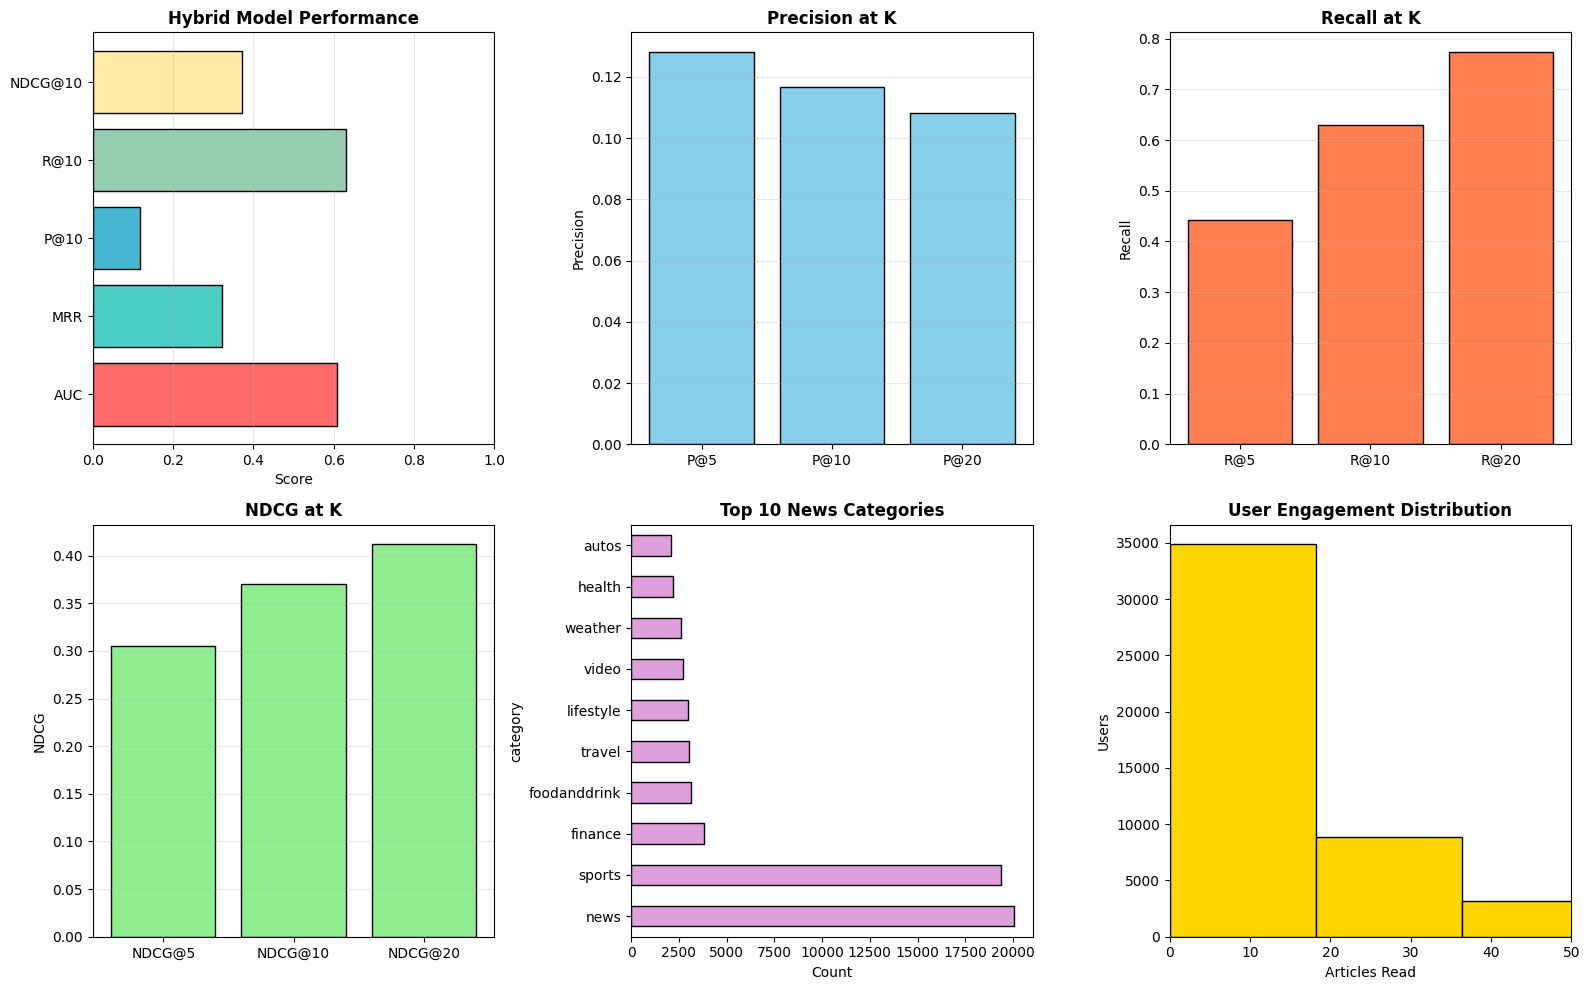

✅ Visualizations saved!



In [ ]:
# ============================================
# STEP 11: Visualizations
# ============================================
print("\n📊 Creating performance visualizations...")

fig = plt.figure(figsize=(16, 10))

# Metrics comparison
plt.subplot(2, 3, 1)
metrics = ['AUC', 'MRR', 'P@10', 'R@10', 'NDCG@10']
values = [hybrid_results['AUC'], hybrid_results['MRR'],
          hybrid_results['Precision@10'], hybrid_results['Recall@10'],
          hybrid_results['NDCG@10']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
plt.barh(metrics, values, color=colors, edgecolor='black')
plt.xlabel('Score')
plt.title('Hybrid Model Performance', fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)

# Precision at K
plt.subplot(2, 3, 2)
k_vals = [5, 10, 20]
precisions = [hybrid_results[f'Precision@{k}'] for k in k_vals]
plt.bar(range(len(k_vals)), precisions, color='skyblue', edgecolor='black')
plt.xticks(range(len(k_vals)), [f'P@{k}' for k in k_vals])
plt.ylabel('Precision')
plt.title('Precision at K', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Recall at K
plt.subplot(2, 3, 3)
recalls = [hybrid_results[f'Recall@{k}'] for k in k_vals]
plt.bar(range(len(k_vals)), recalls, color='coral', edgecolor='black')
plt.xticks(range(len(k_vals)), [f'R@{k}' for k in k_vals])
plt.ylabel('Recall')
plt.title('Recall at K', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# NDCG at K
plt.subplot(2, 3, 4)
ndcgs = [hybrid_results[f'NDCG@{k}'] for k in k_vals]
plt.bar(range(len(k_vals)), ndcgs, color='lightgreen', edgecolor='black')
plt.xticks(range(len(k_vals)), [f'NDCG@{k}' for k in k_vals])
plt.ylabel('NDCG')
plt.title('NDCG at K', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Category distribution
plt.subplot(2, 3, 5)
cat_counts = all_news['category'].value_counts().head(10)
cat_counts.plot(kind='barh', color='plum', edgecolor='black')
plt.xlabel('Count')
plt.title('Top 10 News Categories', fontweight='bold')

# User engagement
plt.subplot(2, 3, 6)
hist_lens = [len(h) for h in train_user_history.values()]
plt.hist(hist_lens, bins=30, color='gold', edgecolor='black')
plt.xlabel('Articles Read')
plt.ylabel('Users')
plt.title('User Engagement Distribution', fontweight='bold')
plt.xlim(0, 50)

plt.tight_layout()
plt.savefig('hybrid_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved!\n")


In [ ]:
# ============================================
# STEP 12: Production Class
# ============================================

class HybridNewsRecommender:
    """Production-ready hybrid news recommender"""

    def __init__(self, news_df, combined_features, item_factors,
                 news_id_to_idx, idx_to_news_id, metrics):
        self.news_df = news_df
        self.combined_features = combined_features
        self.item_factors = item_factors
        self.news_id_to_idx = news_id_to_idx
        self.idx_to_news_id = idx_to_news_id
        self.metrics = metrics

    def recommend(self, user_history, top_n=10, content_weight=0.6, cf_weight=0.4):
        return recommend_hybrid(
            user_history, self.combined_features, self.item_factors,
            self.news_id_to_idx, self.idx_to_news_id, top_n,
            content_weight, cf_weight
        )

    def get_article_details(self, news_ids):
        return self.news_df[self.news_df['news_id'].isin(news_ids)]

    def get_metrics(self):
        return self.metrics

# Initialize
recommender = HybridNewsRecommender(
    all_news, combined_features, item_factors,
    news_id_to_idx, idx_to_news_id, hybrid_results
)

print("="*70)
print("✅ HYBRID NEWS RECOMMENDATION SYSTEM READY!")
print("="*70)
print(f"\n📊 Performance Summary:")
print(f"   AUC: {hybrid_results['AUC']:.4f} | MRR: {hybrid_results['MRR']:.4f}")
print(f"   Precision@10: {hybrid_results['Precision@10']:.4f}")
print(f"   Recall@10: {hybrid_results['Recall@10']:.4f}")
print(f"\n💡 Usage: recommender.recommend(user_history, top_n=10)")
print("="*70)

✅ HYBRID NEWS RECOMMENDATION SYSTEM READY!

📊 Performance Summary:
   AUC: 0.6078 | MRR: 0.3214
   Precision@10: 0.1167
   Recall@10: 0.6291

💡 Usage: recommender.recommend(user_history, top_n=10)
